# College Essay Prompt Clustering (with Spacy)

The goal of this project is to group together similar supplemental essay prompts from colleges in the US. Ultimately, these groups should contain prompts similar enough to be responded to with very similar essays. 

This version of the project uses a Natural Language Processing(NLP) package called Spacy. 

## Importing packages and modules


|Package name|Description|
|------------|-----------|
|numpy     |array-related actions, especially useful for 2D arrays       |
|matplotlib|plotting/graphing       |
|random    |set seed during KMeans (allows for reproducible results)  
|sklearn   |data preprocessing and machine learning algorithms (aka scikit-learn)  
|json      |raw prompt storage and retrieval  
|spacy     |NLP tools, like transformers (sentence --> vector)  

In [81]:
import numpy as np
import matplotlib.pyplot as plt

import random

import sklearn
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

import json

import spacy

nlp = spacy.load("en_core_web_trf")

## Loading in prompts and storing them

Allprompts is a list of lists that stores all the prompts. In the overall list, each element is a list that represents a school. In each school's list, there is a unique number that corresponds to them and a list of tuples with each prompt and its title.

In [82]:
file = open("json_data.json")
 
allprompts = json.load(file)

In [83]:
# number of prompts from each school
numPrompts = []

# list of prompts (sentences), no longer grouped by school
prompt_corpus = []

for college in allprompts:
    numPrompts.append(len(college[1]))

    for prompt in college[1]:
        prompt_corpus.append(prompt[1])

## Transforming Prompts into Vectors

Spacy takes the `prompt_corpus` and performs an entire NLP process on it. `nlp.pipe()` returns an object with all the "docs" (prompts) processed. However, I just want the vector forms of the prompts, which can be accessed through `doc._trf_data.tensors[-1]`. 

**How does Spacy convert a sentence/paragraph into a vector of numbers?**

Essentially, Spacy uses a transformer called roBERTa. Transformers are a kind of deep learning model developed by Google in 2017. Transformers are neural networks with an emphasis on "self-attention" and bidirectionality. What that means in this case is that they consider the context of words and the relationships between words in a sentence.  

roBERTa is a variation of the original nlp transformer developed by Google called BERT. These two models both act similarly. They are pretrained using a huge amount of text, including all of Wikipedia. These models were trained by removing around 15% of the words from a sentence and making them guess the missing words, using the context around the blank.  

Here, roBERTa takes in a sentence (separated earlier in spacy's nlp process), runs it through its pretrained neural network, and produces a vector. 

source: https://www.analyticsvidhya.com/blog/2019/06/understanding-transformers-nlp-state-of-the-art-models/

In [84]:
# transformed vectors extracted from nlp.pipe()
prompt_vectors = []

# the original index of the prompt in the prompt_corpus
prompt_indices = []
i = 0

for doc in nlp.pipe(prompt_corpus):
    transformed_prompt = doc._.trf_data.tensors[-1]
    
    # shape is checked since some prompts are too long and are then transformed into multiple vectors, which I have chosen to omit
    if transformed_prompt.shape == (1,768):
        prompt_vectors.append(transformed_prompt[0])
        prompt_indices.append(i)
    i += 1

# numpy 2D array where each row is a prompt's corresponding vector form
prompt_matrix = np.stack(prompt_vectors, axis=0)

C:\Users\viche\miniconda3\envs\scikit\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [85]:
# (number of prompts, number of features)
print(prompt_matrix.shape)

# adds a column of indices from prompt_indices to the front of the prompt_matrix
prompt_matrix_indexed = np.hstack((np.array(prompt_indices)[:,None], prompt_matrix))

(941, 768)


In [86]:
# extra column now
prompt_matrix_indexed.shape

(941, 769)

In [87]:
# function to convert from the index in the prompt_corpus to the list indices in allprompts
# allows for conversion from vector back to original prompt only using index from first column

def indToDict(index):
#     numPrompts = []
#     for prompts in allprompts:
#         numPrompts.append(len(prompts[1]))
    
    total = 0
    for x in range(len(numPrompts)):
        curr = numPrompts[x]

        # checks if the index is between the number of prompts already passed and 
        # the number of prompts already passed including the current school's prompts
        if (total + curr) > index:
            ind = index - total
            return (x, int(ind))
        
        total += curr

In [88]:
example = indToDict(851)

print(prompt_corpus[851])
print(allprompts[example[0]][1][example[1]][1])

Please briefly elaborate on one of your extracurricular activities or work experiences.
Please briefly elaborate on one of your extracurricular activities or work experiences.


## Dimension Reduction - PCA

Since the data consists of over 900 prompts, each represented by a vector of 768 values assigned by roBERTa, it is impossible to plot it (imagine each prompt is a point: there is no way to plot 768 dimensions). As a result, dimension reduction methods like PCA are used. PCA reduces the number of dimensions (the 768 values) to n components. Here, I've set n to 200, an unusually large number of Pricipal Components (PCs).

In [89]:
pca = PCA(n_components=100)

pca_data = pca.fit_transform(prompt_matrix_indexed[:,1:])

pca_data = np.hstack((np.array(prompt_indices)[:,None], pca_data))

### Scree Plot

This plot visualizes how important each PC is in representing the original data. On the y axis is the percent variance explained by the total number of PCs (x axis). Using this plot, it is easy to pick an optimal number of PCs based on the percent variance (i.e. 20 components if I'm okay with ~80% variance explained). 

29


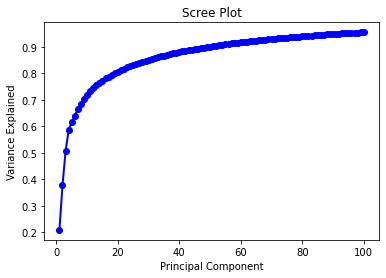

In [90]:
PC_values = np.arange(pca.n_components_) + 1

cumulative_var = [sum(pca.explained_variance_ratio_[0:x+1]) for x in range(len(pca.explained_variance_ratio_))]

i=0
for x in cumulative_var:
    if x > 0.85:
        print(i)
        break
    i+=1
        

plt.plot(PC_values, cumulative_var, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [91]:
# For now, I will choose 4 components, just to make it easier to show

pca = PCA(n_components=4)

pca_data = pca.fit_transform(prompt_matrix_indexed[:,1:])

# again, adds index column 
pca_data = np.hstack((np.array(prompt_indices)[:,None], pca_data))

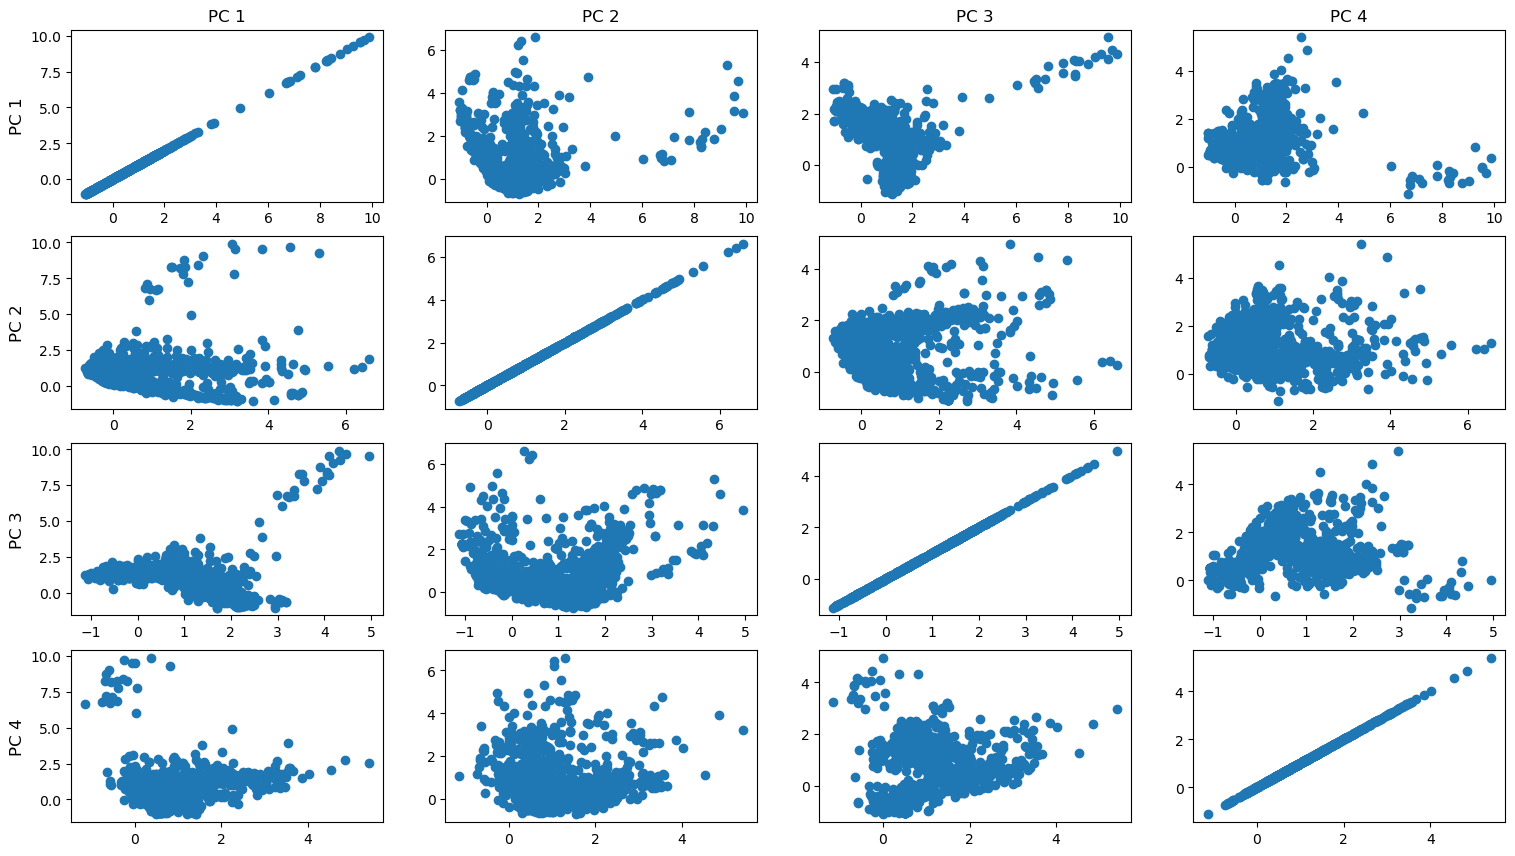

In [92]:
num_comps = pca_data.shape[1]-1

fig, axs = plt.subplots(num_comps, num_comps)

fig.set_size_inches(18.5, 10.5, forward=True)

fig.set_dpi(100)


# creates a grid of plots, where each row has a different PC on its 
# y axis and each column has a different PC on its x axis. 
for i in range(1, num_comps+1):
    for j in range(1, num_comps+1):
        axs[i-1][j-1].scatter(pca_data[:,i]+1, pca_data[:,j]+1)
        if i == 1:
            axs[i-1][j-1].set_title("PC " + str(j))
        if j == 1:
            axs[i-1][j-1].set_ylabel("PC " + str(i), fontsize = "large")

plt.show()

In [93]:
# total percent variance explained by 4 Principal Components
print(sum(pca.explained_variance_ratio_))

0.5856647922958391


## KMeans Clustering

![KMeansUrl](https://i.imgur.com/k4XcapI.gif "chess")

source: https://mubaris.com/posts/kmeans-clustering/

In [94]:
# k-means for any dim, points is list of vectors in n-dim

def select_init(points, k, labels):
    random.seed = (333)

    dist_weights = []
    centroids = []

    centroids.append(np.asarray(random.choice(points)))

    while len(centroids) < k:
        dist_weights = find_distances(points, centroids, labels)
        centroids.append(np.asarray(random.choices(points, weights=dist_weights)[0]))

    return centroids


def find_distances(points, centroids, labels = 0):
    clusters = [[] for x in range(len(centroids))]
    closest_dists = []

    for curr_point in points:

        # should be large enough given that words will rarely 
        #   occur more than even 20 times in one prompt
        min_dist = 100000000
        min_ind = len(centroids)
        for j in range(len(centroids)):
            curr_dist = sum((centroids[j][labels:] - curr_point[labels:]) ** 2) ** 0.5
            
            if curr_dist < min_dist:
                min_dist = curr_dist
        
        closest_dists.append(min_dist)
        
    return closest_dists


def find_clusters(points, centroids, labels = 0):
    clusters = [[] for x in range(len(centroids))]

    for curr_point in points:

        # should be large enough given that words will rarely 
        #   occur more than even 20 times in one prompt
        min_dist = 100000000
        min_ind = len(centroids)
        for j in range(len(centroids)):
            curr_dist = sum((centroids[j][labels:] - curr_point[labels:]) ** 2) ** 0.5
            if curr_dist < min_dist:
                min_dist = curr_dist
                min_ind = j
        
        clusters[min_ind].append(curr_point)

    return clusters


def k_means(points, k, labels = 0):

    centroids = select_init(points, k, labels)


    for center_num in range(k):
        centroids[center_num] = np.asarray(centroids[center_num])
    
    equal_means = 0
    clusters = []

    while equal_means < k:
        clusters = find_clusters(points, centroids, labels)
        
        for i in range(k):
            mean = sum(np.asarray(clusters[i])) / len(clusters[i])

            dim = labels
            curr_equal_means = True
            while (dim < len(points[0])) and curr_equal_means:
                if (mean[dim] != centroids[i][dim]):
                    centroids[i] = mean
                    curr_equal_means = False
                dim += 1
            
            if dim == len(points[0]):
                equal_means += 1
    
    return clusters

### Clustering the PCA Data

63


Text(0.5, 1.0, 'PC 1 vs PC 2 with 2D KMeans clusters')

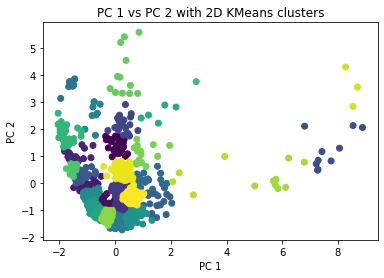

In [95]:
# grabs the first 3 columns of pca_data (column 1 is indices), which contain PCs 1 and 2
pca_points = [list(pca_data[i,0:3]) for i in range(len(pca_data[:,1]))]

num_clusters = 30

pca_clusters = k_means(pca_points, num_clusters, labels = 1)

print(len(pca_clusters[0]))

pca_clusters_graph = []

for c in range(len(pca_clusters)):
    for x in pca_clusters[c]:
        pca_clusters_graph.append(x + [c])

pca_clusters_graph = np.asarray(pca_clusters_graph)

plt.scatter(pca_clusters_graph[:,1], pca_clusters_graph[:,2], c = pca_clusters_graph[:,3])
plt.xlabel("PC 1") 
plt.ylabel("PC 2")
plt.title("PC 1 vs PC 2 with 2D KMeans clusters")

In [113]:
n = 12
print(len(pca_clusters[n]))
for point in pca_clusters[n][0:int(len(pca_clusters[n])/10)]:
    r, c = indToDict(point[0])

    print(allprompts[int(r)][1][int(c)][1])
    print(" ")

72
Students at Yale have time to explore their academic interests before committing to one or more major fields of study. Many students either modify their original academic direction or change their minds entirely. As of this moment, what academic areas seem to fit your interests or goals most comfortably? Please indicate up to three from the list provided.
 
As a research institution that also prides itself on its liberal arts curriculum, Princeton allows students to explore areas across the humanities and the arts, the natural sciences, and the social sciences. What academic areas most pique your curiosity, and how do the programs offered at Princeton suit your particular interests? (Please respond in about 250 words)
 
How does the University of Chicago, as you know it now, satisfy your desire for a particular kind of learning, community, and future? Please address with some specificity your own wishes and how they relate to UChicago.
 
The LSM program aims to provide students with

## Elbow Plot

Elbow plots are useful for determining the optimal number of clusters. In this case, the elbow plot plots the number of clusters against the "inertia".  

Inertia is calculated by first finding the distances between the points in a cluster and the cluster center. Then, these distances are each squared and then all added together to get the inertia. A lower inertia means that the points are closer to their clusters, which is good until there are too many clusters.   

By looking around the elbow of the plot, we can choose an optimal number of clusters.  

NOTE: At this point, KMeans is clustering the multidimensional data, not the PCA data.

In [97]:
elbow = []

for i in range(1, 100):
    # switched to sklearn's built-in KMeans function for "inertia" calculation
    kmeans = KMeans(n_clusters = i, init = "k-means++", random_state = 333)
    kmeans.fit(prompt_matrix_indexed[:,1:])
    elbow.append(kmeans.inertia_)

C:\Users\viche\miniconda3\envs\scikit\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Text(0.5, 1.0, 'KMeans Elbow Plot')

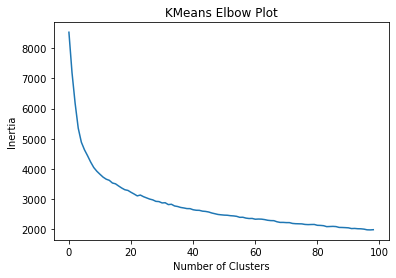

In [98]:
plt.plot(elbow)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("KMeans Elbow Plot")

In [99]:
kmeans = KMeans(n_clusters = 50, init = "k-means++", random_state = 333)

kmeans.fit(prompt_matrix_indexed[:,1:])

KMeans(n_clusters=50, random_state=333)

Text(0.5, 1.0, 'PC 1 vs PC 2 plot with multidimensional KMeans clusters')

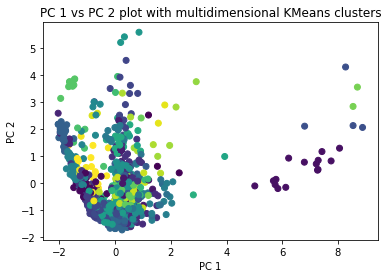

In [100]:
kmeans.labels_.shape

plt.scatter(pca_data[:,1], pca_data[:,2], c = kmeans.labels_)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PC 1 vs PC 2 plot with multidimensional KMeans clusters")

In [101]:
n = 5

count = 0
for p in range(len(kmeans.labels_)):
    if int(kmeans.labels_[p]) == n:
        r, c = indToDict(p)

        print(allprompts[int(r)][1][int(c)][1])
        print("")
        count += 1

print(count)

What brings you joy? 

What excites you?

There is a story or meaning behind every name or nickname—both those we’re given and those that we choose. What is meaningful to you about your name?

Dream trip:

For one week at the end of January, Reed students upend the traditional classroom hierarchy and teach classes about any topic they love, academic or otherwise. This week is known as Paideia after the Greek term signifying “education” – the complete education of mind, body and spirit. What would you teach that would contribute to the Reed community?

What is your favorite subject?

Why are you interested in Wofford College?

Whether they are constructing a robot, a stronger sense of community or an identity, UVM students are builders. What would you like to build? 

Describe a time you did not meet expectations and what impact the experience had on you.


Describe the attributes of a York education that make it a good fit for your future. You may also provide a personal example which 

In [110]:
n = 1

count = 0
cluster_prompts = []

for p in range(len(kmeans.labels_)):
    if int(kmeans.labels_[p]) == n:
        r, c = indToDict(p)

        cluster_prompts.append(allprompts[int(r)][1][int(c)][1])
        count += 1

print(count)

# only prints first ~20% prompts in the cluster
for x in cluster_prompts[0:int(count/5)]:
    print(x)
    print("")

37
Please share with us why you consider Duke a good match for you. Is there something in particular about Duke’s academic or other offerings that attracts you? 

 Discuss your interest in nursing and health care management. How might Penn's coordinated dual-degree program in nursing and business help you meet your goals?

What activities have you performed that demonstrate your ability to work cooperatively with people?

For you, what makes Cornell Engineering special? Why do you want to attend Cornell Engineering?

What academic areas are you interested in exploring in college?

Discuss the reasons you chose Social Work as your first-choice major and how a Social Work degree from UT will prepare you for the future.

Please explain your interest in your first-choice major/undecided status and your second-choice major, should you opt to list one.



## Other Clustering Algorithms

Here, I attempt to use HDBSCAN, a popular clustering algorithm for high-dimensional data. However, one thing that is unique about HDBSCAN is that it does not need to put everything in a cluster. It can also simply not cluster something if it believes that it is an outlier/noise. When it does so, it labels these points with the number -1. 

In [103]:
import hdbscan

cluster_obj = hdbscan.HDBSCAN(min_cluster_size=5, min_samples = 1)

# cluster_obj = hdbscan.HDBSCAN()

cluster_obj.fit(prompt_matrix)

HDBSCAN(min_samples=1)

In [104]:
unclustered_counter = 0

for x in cluster_obj.labels_:
    if x == -1:
        unclustered_counter += 1

print(str(unclustered_counter) + " unclustered points")
print("~" + str(int(unclustered_counter / len(cluster_obj.labels_) * 10000) / 100.0) + "% are unclustered")

# number of clusters
print("")
print("Number of clusters: " + str(max(cluster_obj.labels_)))

553 unclustered points
~58.76% are unclustered

Number of clusters: 21


### tSNE Plot

tSNE is another method of dimension reduction that is especially useful for preserving aspects of high-dimensional data. 

C:\Users\viche\miniconda3\envs\scikit\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\viche\miniconda3\envs\scikit\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'tSNE plot colored by HDBSCAN clusters')

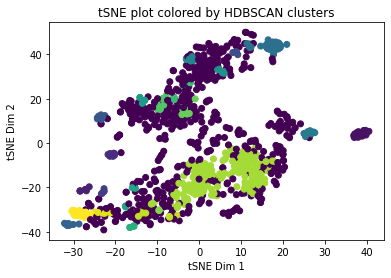

In [105]:
np.random.seed(333)

projection = sklearn.manifold.TSNE().fit_transform(prompt_matrix)
plt.scatter(*projection.T, c=cluster_obj.labels_)


plt.xlabel("tSNE Dim 1")
plt.ylabel("tSNE Dim 2")
plt.title("tSNE plot colored by HDBSCAN clusters")

### PCA Plots with HDBSCAN Clusters

This was an attempt to see if there was any pattern with the unclustered points. 

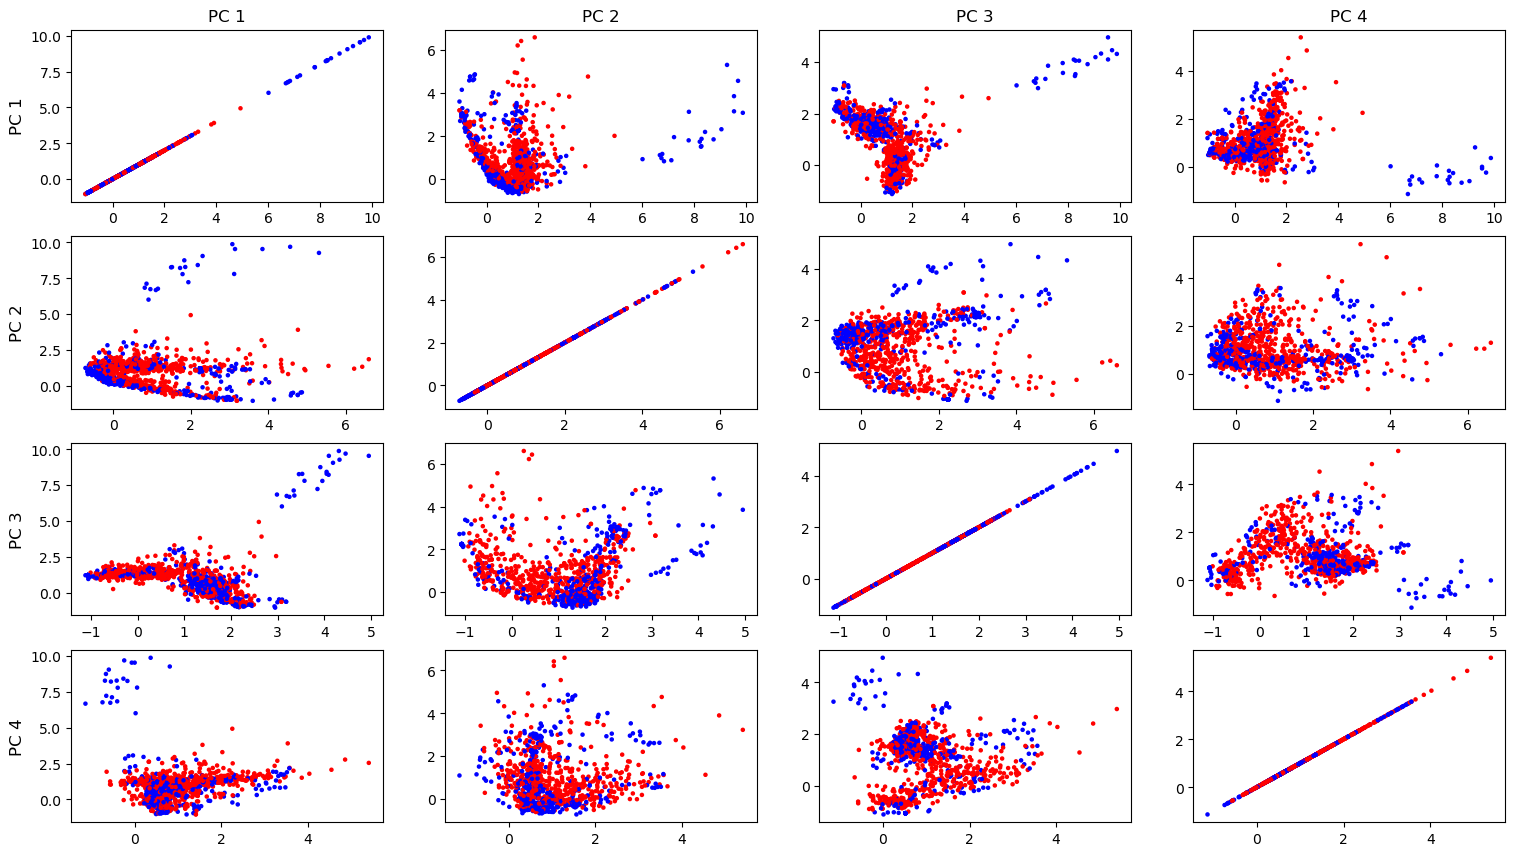

In [106]:
fig, axs = plt.subplots(num_comps, num_comps)

fig.set_size_inches(18.5, 10.5, forward=True)

fig.set_dpi(100)

for i in range(1, num_comps+1):
    for j in range(1, num_comps+1):
        axs[i-1][j-1].scatter(pca_data[:,i]+1, pca_data[:,j]+1, c = ["red" if x < 0 else "blue" for x in cluster_obj.labels_], s=[5 if x < 0 else 5 for x in cluster_obj.labels_])
        if i == 1:
            axs[i-1][j-1].set_title("PC " + str(j))
        if j == 1:
            axs[i-1][j-1].set_ylabel("PC " + str(i), fontsize = "large")

## Conclusion

Currently, my goals are to continue exploring the vast number of tools offered by the Spacy library. However, the main issue that I believe I've found is that the data itself is not ideal. For starters, the website that I'm getting the college prompts from has a number of typos, which just makes the data noisy.  

Furthermore, the data itself may not be suited for NLP. College prompts vary a lot, yet they are relatively short. This makes it difficult for algorithms to find the meaning of a prompt, let alone determine if it asks a similar question as another prompt.  

I still plan to work on this project, and I am considering a variety of ways to try and progress. But overall, I've learned quite a lot regarding NLP, machine learning, and AI during this class!